
El análisis de sentimientos es una herramienta utilizada en márquetin para poder determinar el sentido de la opinión de los consumidores de un producto o servicio. Es bastante caro el ir haciendo encuestas periódicas para obtener esa información, por lo que se puede intentar obtener de manera indirecta a partir de los mensajes que la gente deja en las redes sociales. El elemento clave es tener un clasificador para esos mensajes que nos dé el sentido de esa opinión. El conjunto de datos airlines recoge una colección de tweets sobre la opinión de personas sobre líneas aéreas etiquetadas como positivas, neutras o negativas. En este caso para simplificar se han unido las categorías positiva y neutra.

---

Sentiment analysis is a tool used in marketing to determine the sentiment of consumers' opinions about a product or service. Conducting periodic surveys to obtain this information can be quite expensive, so it can be attempted indirectly through the messages people leave on social media. The key element is to have a classifier for these messages that provides us with the sentiment of those opinions. The airlines dataset collects a collection of tweets about people's opinions on airlines, categorized as positive, neutral, or negative. In this case, to simplify, the positive and neutral categories have been combined.

Dataset: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/

In [22]:
%pip install apafib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from sklearn.metrics import classification_report
from apafib import load_sentiment


In [24]:
train_size = 0.8 # Porcentaje de datos para entrenamiento
nwords = [500, 1500, 3000] # Número de palabras a considerar

# Establecer semillas aleatorias para reproducibilidad
seed_value = 2023
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)

In [25]:
# Cargar datos
# load_sentiment(nwords, train_size) regresa los conjuntos de datos de entrenamiento, validación y prueba
# Esta función recibe un parámetro que corresponde al número de palabras más frecuentes que se usarán para
# extraer las características del conjunto de datos (nwords) y el porcentaje de datos que corresponde al conjunto 
# de entrenamiento (train_size) que por defecto es 0.8. La función retornará seis matrices que corresponden al conjunto 
# de entrenamiento y sus etiquetas, el conjunto de validación y sus etiquetas y el conjunto de test y sus etiquetas. 
# El tamaño de los conjuntos de validación y test corresponde a los que no entren en el conjunto de entrenamiento dividido a partes iguales.

# This function takes a parameter corresponding to the number of most frequent words that will be used to
# extract features from the dataset (nwords) and the percentage of data corresponding to the training set
# (train_size), which defaults to 0.8. The function will return six matrices corresponding to the training
# set and its labels, the validation set and its labels, and the test set and its labels.
# The size of the validation and test sets corresponds to those that do not enter the training set divided equally.

# nwords = 500
X_train_500, y_train_500, X_val_500, y_val_500, X_test_500, y_test_500 = load_sentiment(nwords=nwords[0], train_size=train_size)

# nwords = 1500
X_train_1500, y_train_1500, X_val_1500, y_val_1500, X_test_1500, y_test_1500 = load_sentiment(nwords=nwords[1], train_size=train_size)

# nwords = 3000
X_train_3000, y_train_3000, X_val_3000, y_val_3000, X_test_3000, y_test_3000 = load_sentiment(nwords=nwords[2], train_size=train_size)


In [26]:
def visualize_train_data(train_x, train_y):
    # Reducir la dimensionalidad con PCA
    pca = PCA(n_components=10, random_state=seed_value )  # Ajusta el número de componentes principales según sea necesario
    X_train_pca = pca.fit_transform(train_x)

    # Utilizar t-SNE inicializado con PCA
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, init='pca', random_state=seed_value)
    X_train_tsne = tsne.fit_transform(X_train_pca)

    # Graficar los resultados
    plt.figure(figsize=(10, 8))
    colors = np.array(['red', 'green'])
    plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=colors[train_y], label=['Negative', 'Positive/Neutral'])
    plt.title('t-SNE Visualization of Training Data (PCA initialized)')
    plt.legend()
    plt.show()

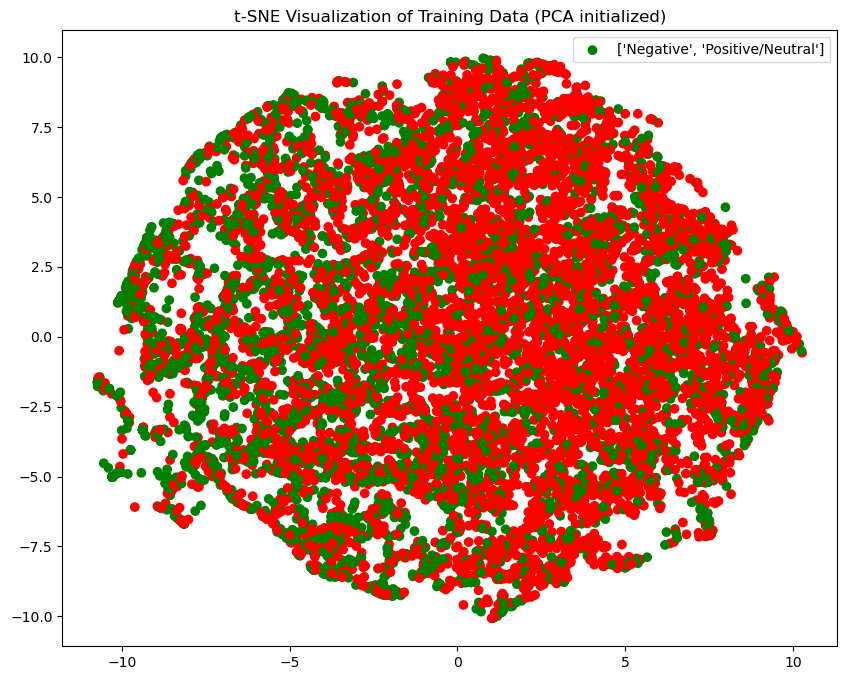

In [27]:
visualize_train_data(X_train_500, y_train_500)

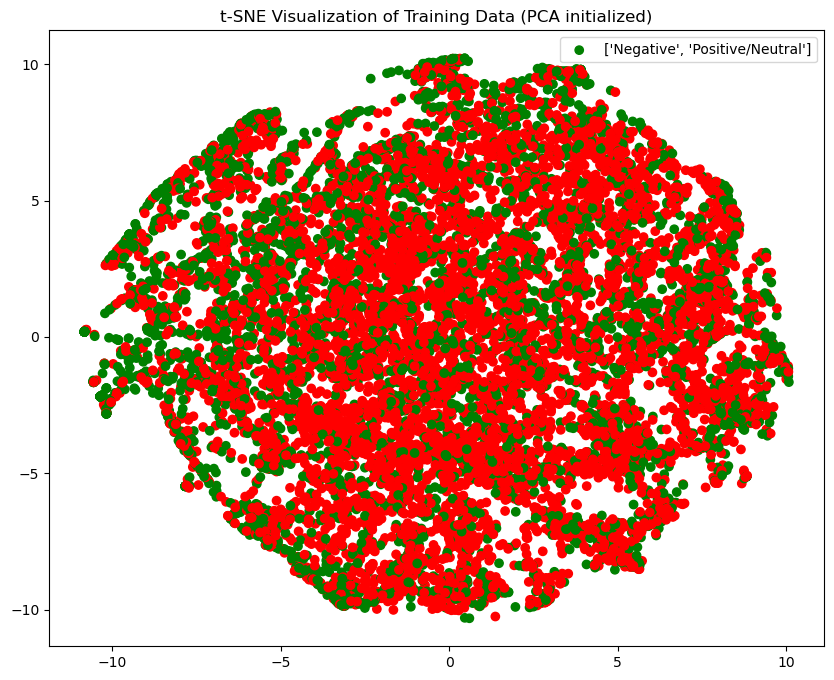

In [28]:
visualize_train_data(X_train_1500, y_train_1500)

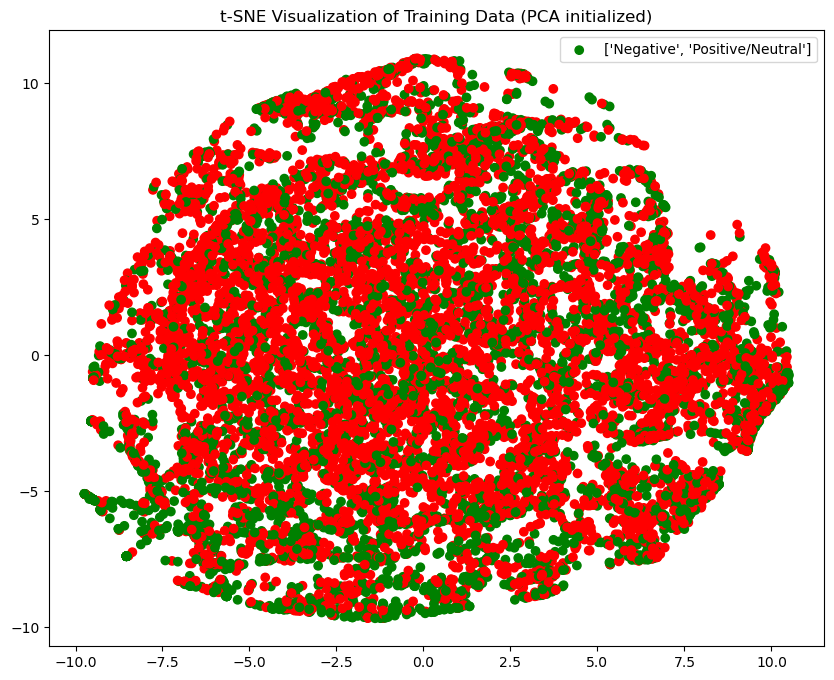

In [29]:
visualize_train_data(X_train_3000, y_train_3000)

Podemos observar como claramente en ninguno de los tres conjuntos podemos hacer una distinción clara entre una clase y otra. Está claro que la disminución de la dimensionalidad nos hace perder mucha calidad a la hora de separar las clases. Necesitamos de herramientas que permitan hacer esta separación usando la alta dimensionalidad de los datos.

------

We can clearly observe that none of the three sets allow for a clear distinction between one class and another. It is evident that reducing dimensionality results in a significant loss of quality when separating classes. We need tools that enable us to achieve this separation while utilizing the high dimensionality of the data.

In [30]:
def plot_metrics(res):
    # Visualizar la pérdida de entrenamiento y validación a lo largo de las épocas
    plt.plot(res.history['loss'], label='Training Loss')
    plt.plot(res.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Visualizar la precisión de entrenamiento y validación a lo largo de las épocas
    plt.plot(res.history['accuracy'], label='Training Accuracy')
    plt.plot(res.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [31]:
def plot_acuracies(sizes, train_accuracies, test_accuracies, val_accuracies, title, i):
    # Graficar los resultados
    plt.plot(sizes, train_accuracies, marker='o', label='Training Accuracy', color='red')
    plt.plot(sizes, test_accuracies, marker='o', label='Testing Accuracy', color='green')
    plt.plot(sizes, val_accuracies, marker='o', label='Validation Accuracy', color='blue')
    plt.title(f'Effect of {title} on Accuracy for {nwords[i]} Words')
    plt.xlabel(title)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [32]:
def plot_epochs(patience_values, patience_epochs):
    # Graficar los resultados
    plt.plot(patience_values, patience_epochs[nwords[0]], marker='o', label=f'Epochs for {nwords[0]} Words', color='red')
    plt.plot(patience_values, patience_epochs[nwords[1]], marker='o', label=f'Epochs for {nwords[1]} Words', color='green')
    plt.plot(patience_values, patience_epochs[nwords[2]], marker='o', label=f'Epochs for {nwords[2]} Words', color='blue')
    plt.title(f'Effect of Patience on Epochs')
    plt.xlabel('Patience value')
    plt.ylabel('Epochs')
    plt.legend()
    plt.show()


In [33]:
def plot_histories(hist_accuracy, hist_val_accuracy, title, k):
    # Graficar los resultados
    for i in range(1,5):
        plt.plot(hist_accuracy[i], label=f'Accuracy for {i} hidden layers')
        plt.plot(hist_val_accuracy[i], label=f'Validation Accuracy for {i} hidden layers')

    plt.title(f'Validation Accuracy for Different Hidden Layers, in a Vocabulary of {nwords[k]} Words')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [34]:
embedding_size = 50
nneurons = 100
embedding_sizes = list(range(5, 31, 5))
best_embedding_size = {}
worst_embedding_size = {}
embedding_train_accuracies = {}
embedding_test_accuracies = {}
embedding_val_accuracies = {}

In [35]:
# Función para construir y entrenar el modelo
def train_model(embedding_size, patience_value, i, train_x, train_y, val_x, val_y, test_x, test_y):
    model = Sequential()
    model.add(Embedding(nwords[i] + 1, embedding_size, input_length=train_x.shape[1]))
    model.add(Dense(128, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Configurar devolución temprana
    early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_value)
    check = keras.callbacks.ModelCheckpoint('modelckpt',
                                        monitor='val_loss',
                                        save_best_only=True,
                                        save_weights_only=True)

    # Entrenar el modelo
    res = model.fit(train_x, train_y,
                        batch_size=512,
                        epochs=100,
                        validation_data=(val_x, val_y),
                        callbacks=[early, check])

    # Añadir aqui el código para guardar el modelo

    # Evaluar el modelo
    _, train_accuracy = model.evaluate(train_x, train_y)
    _, val_accuracy = model.evaluate(val_x, val_y)
    _, test_accuracy = model.evaluate(test_x, test_y)
    
    return train_accuracy, test_accuracy, val_accuracy, len(res.history['loss'])
    
'''
    # Definir la ruta del archivo de pesos
    weights_path = f'./model_{nwords[i]}.ckpt'

    # Verificar si el archivo de pesos existe
    if os.path.exists(weights_path):
        # Si existe, cargar el modelo existente
        model.load_weights(weights_path)
    else:
        # Si no existe, crear y entrenar un nuevo modelo
        print(f'El archivo {weights_path} no existe. Creando y entrenando un nuevo modelo.')

        # Guardar los pesos del nuevo modelo
        model.save_weights(weights_path)
'''



"\n    # Definir la ruta del archivo de pesos\n    weights_path = f'./model_{nwords[i]}.ckpt'\n\n    # Verificar si el archivo de pesos existe\n    if os.path.exists(weights_path):\n        # Si existe, cargar el modelo existente\n        model.load_weights(weights_path)\n    else:\n        # Si no existe, crear y entrenar un nuevo modelo\n        print(f'El archivo {weights_path} no existe. Creando y entrenando un nuevo modelo.')\n\n        # Guardar los pesos del nuevo modelo\n        model.save_weights(weights_path)\n"

In [36]:
# Parámetros
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Experimentar con diferentes tamaños de embedding
for size in embedding_sizes:
    print(f"Training with embedding size: {size}")
    train_accuracy, test_accuracy, val_accuracy, epochs = train_model(size, 10, 0, X_train_500, y_train_500, X_val_500, y_val_500, X_test_500, y_test_500)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)

embedding_train_accuracies[500] = train_accuracies
embedding_test_accuracies[500] = test_accuracies
embedding_val_accuracies[500] = val_accuracies
best_embedding_size[500] = embedding_sizes[np.argmax(test_accuracies)]
worst_embedding_size[500] = embedding_sizes[np.argmin(test_accuracies)]

Training with embedding size: 5
Epoch 1/100
23/23 [==============================] - 1s 24ms/step - loss: 0.6723 - accuracy: 0.6060 - val_loss: 0.6289 - val_accuracy: 0.6573
Epoch 2/100
23/23 [==============================] - 0s 16ms/step - loss: 0.6285 - accuracy: 0.6246 - val_loss: 0.5635 - val_accuracy: 0.7438
Epoch 3/100
23/23 [==============================] - 0s 15ms/step - loss: 0.5633 - accuracy: 0.7140 - val_loss: 0.5143 - val_accuracy: 0.7534
Epoch 4/100
23/23 [==============================] - 0s 13ms/step - loss: 0.5094 - accuracy: 0.7481 - val_loss: 0.4774 - val_accuracy: 0.7699
Epoch 5/100
23/23 [==============================] - 0s 13ms/step - loss: 0.4617 - accuracy: 0.7821 - val_loss: 0.4547 - val_accuracy: 0.7740
Epoch 6/100
23/23 [==============================] - 0s 14ms/step - loss: 0.4291 - accuracy: 0.8040 - val_loss: 0.4440 - val_accuracy: 0.7905
Epoch 7/100
23/23 [==============================] - 0s 16ms/step - loss: 0.4101 - accuracy: 0.8119 - val_loss: 0.43

In [37]:
# Parámetros
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Experimentar con diferentes tamaños de embedding
for size in embedding_sizes:
    print(f"Training with embedding size: {size}")
    train_accuracy, test_accuracy, val_accuracy, epochs = train_model(size, 10, 1, X_train_1500, y_train_1500, X_val_1500, y_val_1500, X_test_1500, y_test_1500)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)

embedding_train_accuracies[1500] = train_accuracies
embedding_test_accuracies[1500] = test_accuracies
embedding_val_accuracies[1500] = val_accuracies
best_embedding_size[1500] = embedding_sizes[np.argmax(test_accuracies)]
worst_embedding_size[1500] = embedding_sizes[np.argmin(test_accuracies)]

Training with embedding size: 5
Epoch 1/100
23/23 [==============================] - 1s 26ms/step - loss: 0.6699 - accuracy: 0.5992 - val_loss: 0.6216 - val_accuracy: 0.6568
Epoch 2/100
23/23 [==============================] - 0s 15ms/step - loss: 0.6202 - accuracy: 0.6493 - val_loss: 0.5515 - val_accuracy: 0.7479
Epoch 3/100
23/23 [==============================] - 0s 15ms/step - loss: 0.5605 - accuracy: 0.7116 - val_loss: 0.5072 - val_accuracy: 0.7589
Epoch 4/100
23/23 [==============================] - 0s 15ms/step - loss: 0.4977 - accuracy: 0.7540 - val_loss: 0.4571 - val_accuracy: 0.7925
Epoch 5/100
23/23 [==============================] - 0s 13ms/step - loss: 0.4286 - accuracy: 0.8098 - val_loss: 0.4248 - val_accuracy: 0.8068
Epoch 6/100
23/23 [==============================] - 0s 16ms/step - loss: 0.3830 - accuracy: 0.8320 - val_loss: 0.4070 - val_accuracy: 0.8240
Epoch 7/100
23/23 [==============================] - 0s 16ms/step - loss: 0.3563 - accuracy: 0.8457 - val_loss: 0.39

In [38]:
# Parámetros
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Experimentar con diferentes tamaños de embedding
for size in embedding_sizes:
    print(f"Training with embedding size: {size}")
    train_accuracy, test_accuracy, val_accuracy, epochs = train_model(size, 10, 2, X_train_3000, y_train_3000, X_val_3000, y_val_3000, X_test_3000, y_test_3000)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)

embedding_train_accuracies[3000] = train_accuracies
embedding_test_accuracies[3000] = test_accuracies
embedding_val_accuracies[3000] = val_accuracies
best_embedding_size[3000] = embedding_sizes[np.argmax(test_accuracies)]
worst_embedding_size[3000] = embedding_sizes[np.argmin(test_accuracies)]

Training with embedding size: 5
Epoch 1/100
23/23 [==============================] - 1s 23ms/step - loss: 0.6692 - accuracy: 0.6016 - val_loss: 0.6188 - val_accuracy: 0.6571
Epoch 2/100
23/23 [==============================] - 0s 15ms/step - loss: 0.6148 - accuracy: 0.6445 - val_loss: 0.5494 - val_accuracy: 0.7413
Epoch 3/100
23/23 [==============================] - 0s 16ms/step - loss: 0.5457 - accuracy: 0.7228 - val_loss: 0.4984 - val_accuracy: 0.7598
Epoch 4/100
23/23 [==============================] - 0s 17ms/step - loss: 0.4751 - accuracy: 0.7715 - val_loss: 0.4508 - val_accuracy: 0.7858
Epoch 5/100
23/23 [==============================] - 0s 18ms/step - loss: 0.4112 - accuracy: 0.8132 - val_loss: 0.4207 - val_accuracy: 0.8029
Epoch 6/100
23/23 [==============================] - 0s 16ms/step - loss: 0.3618 - accuracy: 0.8456 - val_loss: 0.4106 - val_accuracy: 0.8145
Epoch 7/100
23/23 [==============================] - 0s 14ms/step - loss: 0.3303 - accuracy: 0.8575 - val_loss: 0.39

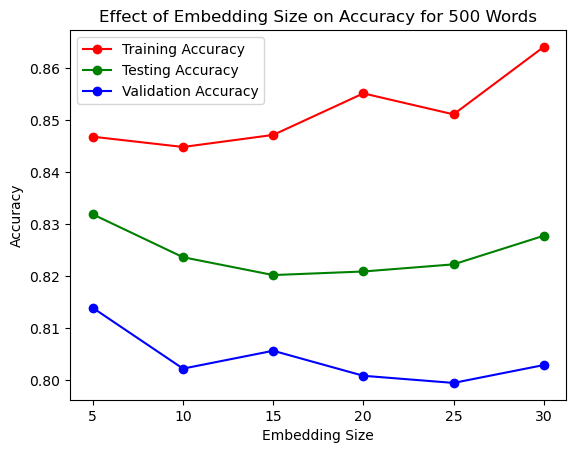

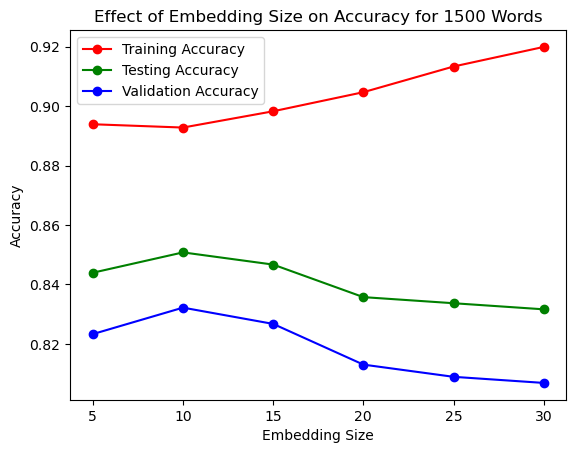

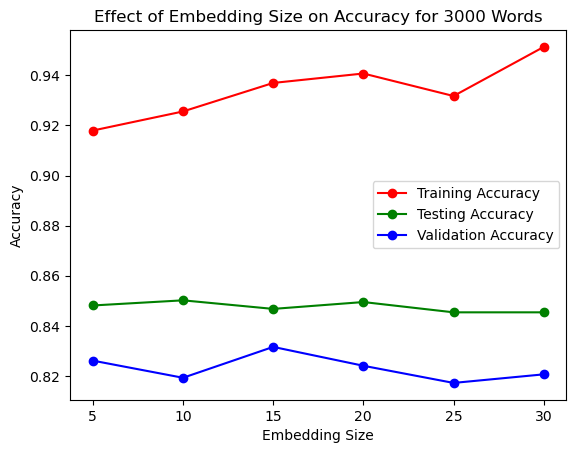

Best embedding size for 500 words: (5, 0.8318462371826172)
Worst embedding size for 500 words: (15, 0.8201784491539001)
Diference between best and worst embedding size for 500 words: 0.011667788028717041
Best embedding size for 1500 words: (10, 0.8507871031761169)
Worst embedding size for 1500 words: (30, 0.8316221833229065)
Diference between best and worst embedding size for 1500 words: 0.01916491985321045
Best embedding size for 3000 words: (10, 0.8502051830291748)
Worst embedding size for 3000 words: (25, 0.8454172611236572)
Diference between best and worst embedding size for 3000 words: 0.004787921905517578


In [39]:
# Graficar los resultados para cada tamaño de embedding
for i in range(3):
    plot_acuracies(embedding_sizes, embedding_train_accuracies[nwords[i]], embedding_test_accuracies[nwords[i]], embedding_val_accuracies[nwords[i]], 'Embedding Size', i)

for i in range(3):
    print(f"Best embedding size for {nwords[i]} words: {best_embedding_size[nwords[i]], embedding_test_accuracies[nwords[i]][int(best_embedding_size[nwords[i]]/5) -1]}")
    print(f"Worst embedding size for {nwords[i]} words: {worst_embedding_size[nwords[i]], embedding_test_accuracies[nwords[i]][int(worst_embedding_size[nwords[i]]/5) -1]}")
    print(f"Diference between best and worst embedding size for {nwords[i]} words: {embedding_test_accuracies[nwords[i]][int(best_embedding_size[nwords[i]]/5) -1] - embedding_test_accuracies[nwords[i]][int(worst_embedding_size[nwords[i]]/5) -1]}")
    

Observamos que no hay un cambio drástico en el aumento del tamaño de embedding. Hemos calculado la diferencia entre los mejores y peores valores de accuracy en el conjunto de tests. Como podemos apreciar en el output anterior, ninguna de las diferencias de los tres conjuntos supera 2%, lo cual es un valor despreciable al tratarse de, como mucho, un 1.19%. De todas formas, aprovecharemos el vector best_embedding_values, para el siguiente experimento, así usaremos el mejor valor obtenido (con el conjunto de test) para cada conjunto de datos.

---------

We observe that there is no drastic change in the increase in embedding size. We have calculated the difference between the best and worst accuracy values in the test set. As we can see in the previous output, none of the differences in the three sets exceeds 2%, which is negligible considering that it is at most 1.19%. Nevertheless, we will utilize the vector best_embedding_values for the next experiment, thus using the best value obtained (with the test set) for each dataset.

In [40]:
# Parámetros
patience_values = list(range(5, 21, 5))

patience_train_accuracies = {}
patience_test_accuracies = {}
patience_val_accuracies = {}
patience_epochs = {}
best_patience_value = {}

In [41]:
# Parámetros
train_accuracies = []
test_accuracies = []
val_accuracies = []
total_epochs = []

for patience in patience_values:
    print(f"Training with patience: {patience}")
    train_accuracy, test_accuracy, val_accuracy, epochs = train_model(best_embedding_size[500], patience, 0, X_train_500, y_train_500, X_val_500, y_val_500, X_test_500, y_test_500)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)
    total_epochs.append(epochs)

patience_train_accuracies[500] = train_accuracies
patience_test_accuracies[500] = test_accuracies
patience_val_accuracies[500] = val_accuracies
patience_epochs[500] = total_epochs
best_patience_value[500] = patience_values[np.argmax(test_accuracies)]

Training with patience: 5
Epoch 1/100
23/23 [==============================] - 1s 25ms/step - loss: 0.6698 - accuracy: 0.6048 - val_loss: 0.6196 - val_accuracy: 0.6573
Epoch 2/100
23/23 [==============================] - 0s 14ms/step - loss: 0.6153 - accuracy: 0.6488 - val_loss: 0.5498 - val_accuracy: 0.7390
Epoch 3/100
23/23 [==============================] - 0s 12ms/step - loss: 0.5588 - accuracy: 0.7135 - val_loss: 0.5131 - val_accuracy: 0.7486
Epoch 4/100
23/23 [==============================] - 0s 14ms/step - loss: 0.5093 - accuracy: 0.7488 - val_loss: 0.4769 - val_accuracy: 0.7720
Epoch 5/100
23/23 [==============================] - 0s 13ms/step - loss: 0.4626 - accuracy: 0.7826 - val_loss: 0.4528 - val_accuracy: 0.7802
Epoch 6/100
23/23 [==============================] - 0s 13ms/step - loss: 0.4292 - accuracy: 0.8033 - val_loss: 0.4409 - val_accuracy: 0.7912
Epoch 7/100
23/23 [==============================] - 0s 14ms/step - loss: 0.4090 - accuracy: 0.8146 - val_loss: 0.4335 - v

In [42]:
# Parámetros
train_accuracies = []
test_accuracies = []
val_accuracies = []
total_epochs = []

for patience in patience_values:
    print(f"Training with patience: {patience}")
    train_accuracy, test_accuracy, val_accuracy, epochs = train_model(best_embedding_size[1500], patience, 1, X_train_1500, y_train_1500, X_val_1500, y_val_1500, X_test_1500, y_test_1500)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)
    total_epochs.append(epochs)

patience_train_accuracies[1500] = train_accuracies
patience_test_accuracies[1500] = test_accuracies
patience_val_accuracies[1500] = val_accuracies
patience_epochs[1500] = total_epochs
best_patience_value[1500] = patience_values[np.argmax(test_accuracies)]

Training with patience: 5


Epoch 1/100
23/23 [==============================] - 1s 22ms/step - loss: 0.6671 - accuracy: 0.6049 - val_loss: 0.6141 - val_accuracy: 0.6568
Epoch 2/100
23/23 [==============================] - 0s 15ms/step - loss: 0.6055 - accuracy: 0.6575 - val_loss: 0.5343 - val_accuracy: 0.7411
Epoch 3/100
23/23 [==============================] - 0s 16ms/step - loss: 0.5334 - accuracy: 0.7301 - val_loss: 0.4823 - val_accuracy: 0.7699
Epoch 4/100
23/23 [==============================] - 0s 16ms/step - loss: 0.4560 - accuracy: 0.7872 - val_loss: 0.4354 - val_accuracy: 0.8021
Epoch 5/100
23/23 [==============================] - 0s 17ms/step - loss: 0.3947 - accuracy: 0.8266 - val_loss: 0.4145 - val_accuracy: 0.8103
Epoch 6/100
23/23 [==============================] - 0s 17ms/step - loss: 0.3612 - accuracy: 0.8440 - val_loss: 0.4044 - val_accuracy: 0.8219
Epoch 7/100
23/23 [==============================] - 0s 17ms/step - loss: 0.3397 - accuracy: 0.8516 - val_loss: 0.3982 - val_accuracy: 0.8260
Epoch 

In [43]:
# Parámetros
train_accuracies = []
test_accuracies = []
val_accuracies = []
total_epochs = []

for patience in patience_values:
    print(f"Training with patience: {patience}")
    train_accuracy, test_accuracy, val_accuracy, epochs = train_model(best_embedding_size[3000], patience, 2, X_train_3000, y_train_3000, X_val_3000, y_val_3000, X_test_3000, y_test_3000)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)
    total_epochs.append(epochs)
    print(f"Train Accuracy with embedding size {size}: {train_accuracy}")
    print(f"Test Accuracy with embedding size {size}: {test_accuracy}")
    print(f"Validation Accuracy with embedding size {size}: {val_accuracy}")

patience_train_accuracies[3000] = train_accuracies
patience_test_accuracies[3000] = test_accuracies
patience_val_accuracies[3000] = val_accuracies
patience_epochs[3000] = total_epochs
best_patience_value[3000] = patience_values[np.argmax(test_accuracies)]

Training with patience: 5
Epoch 1/100
23/23 [==============================] - 1s 24ms/step - loss: 0.6699 - accuracy: 0.5979 - val_loss: 0.6213 - val_accuracy: 0.6571
Epoch 2/100
23/23 [==============================] - 0s 15ms/step - loss: 0.6170 - accuracy: 0.6456 - val_loss: 0.5501 - val_accuracy: 0.7488
Epoch 3/100
23/23 [==============================] - 0s 15ms/step - loss: 0.5481 - accuracy: 0.7197 - val_loss: 0.4980 - val_accuracy: 0.7598
Epoch 4/100
23/23 [==============================] - 0s 15ms/step - loss: 0.4685 - accuracy: 0.7766 - val_loss: 0.4421 - val_accuracy: 0.7912
Epoch 5/100
23/23 [==============================] - 0s 15ms/step - loss: 0.3929 - accuracy: 0.8270 - val_loss: 0.4104 - val_accuracy: 0.8090
Epoch 6/100
23/23 [==============================] - 0s 15ms/step - loss: 0.3428 - accuracy: 0.8529 - val_loss: 0.4045 - val_accuracy: 0.8111
Epoch 7/100
23/23 [==============================] - 0s 15ms/step - loss: 0.3129 - accuracy: 0.8662 - val_loss: 0.3932 - v

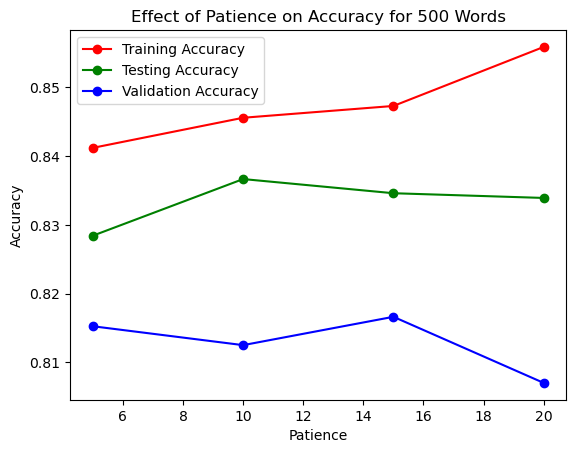

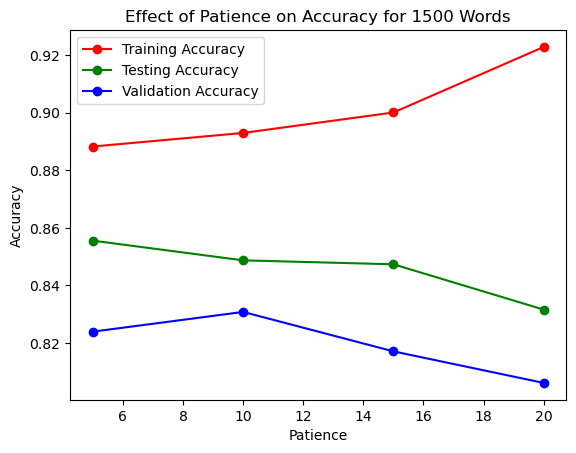

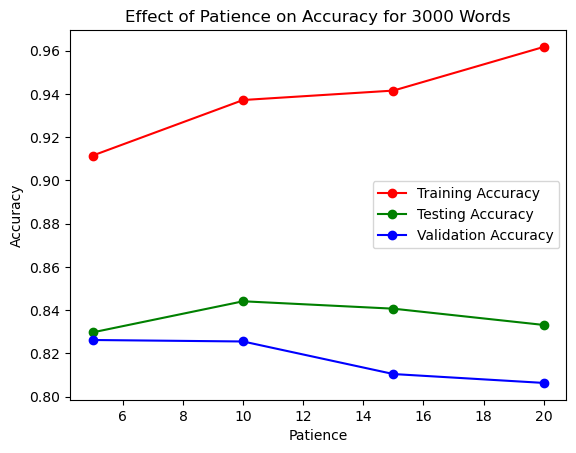

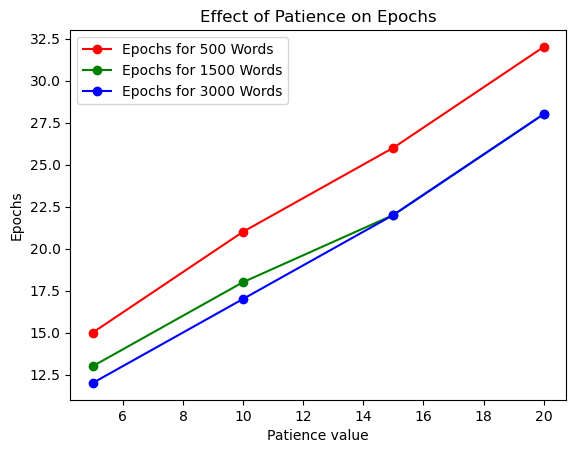

{500: 10, 1500: 5, 3000: 10}


In [44]:
# Graficar los resultados para cada valor de paciencia
for i in range(3):
    plot_acuracies(patience_values, patience_train_accuracies[nwords[i]], patience_test_accuracies[nwords[i]], patience_val_accuracies[nwords[i]], 'Patience', i)

plot_epochs(patience_values, patience_epochs)
print(best_patience_value)

Por un lado, vemos que tanto el primer como el tercer conjunto, la paciencia que ha obtenido mejor accuracy con los datos de prueba Test ha sido 10. Por otro lado, vemos que para el segundo, nos sale 5 y 10 para el conjunto de Validación i 5 con el de test, por tanto, para hacerlo manera homogénea para todos los conjuntos, usaremos patiece_value = 10 para el resto de los experimentos.

En cuanto a la evolución de las epochs totales según el valor de la paciencia, vemos que para todos los conjuntos aumenta de manera similar, sin embargo, para el segundo conjunto a partir de la epoch 20 se comporta como el conjunto de 3000 palabras.

Sin duda este experimento nos has sido útil para ver que, por un lado, la paciencia la podemos reducir en dos de los conjuntos y, por otro lado, para estudiar como evoluciona las epochs según la paciencia que usemos.

--------------------

On one hand, we observe that both the first and third datasets achieved better accuracy with a patience value of 10 on the test data. On the other hand, for the second dataset, we obtained a patience value of 5 for the validation set and 10 for the test set. Therefore, to ensure consistency across all datasets, we will use a patience value of 10 for the rest of the experiments.

Regarding the evolution of total epochs according to the patience value, we see a similar increase for all datasets. However, for the second dataset, starting from epoch 20, it behaves similarly to the dataset with 3000 words.

Undoubtedly, this experiment has been useful for determining that, on one hand, we can reduce the patience value for two of the datasets, and on the other hand, to study how the epochs evolve according to the patience value we use.

In [45]:
# Parámetros
patience_value = 10

In [46]:
# Función para construir y entrenar el modelo
def train_model_num_layers(embedding_size, patience_value, num_layers, i, train_x, train_y, val_x, val_y, test_x, test_y):
    model = Sequential()
    model.add(Embedding(nwords[i] + 1, embedding_size, input_length=train_x.shape[1]))

    # Agregar capas densas
    for layer in range(num_layers):
        layer_size = 128 // (2 ** layer)  # El tamaño de la capa es la mitad de la capa anterior
        model.add(Dense(layer_size, activation='relu'))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Configurar devolución temprana
    early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_value)
    check = keras.callbacks.ModelCheckpoint('modelckpt',
                                        monitor='val_loss',
                                        save_best_only=True,
                                        save_weights_only=True)

    # Entrenar el modelo
    res = model.fit(train_x, train_y,
                        batch_size=512,
                        epochs=50,  # Puedes ajustar este número según sea necesario
                        validation_data=(val_x, val_y),
                        callbacks=[early, check])
    
    # Añadir aqui el código para cargar el modelo
    
    return res.history['accuracy'], res.history['val_accuracy'], model.predict(test_x)
'''
    # Cargar el mejor modelo
    weights_path = f'./model_{nwords[i]}_{num_layers}_layers.h5'
    
    if os.path.exists(weights_path):
        model.load_weights(weights_path)
    else:
        print(f'El archivo {weights_path} no existe. Creando y entrenando un nuevo modelo.')
        model.save_weights(weights_path)
'''



"\n    # Cargar el mejor modelo\n    weights_path = f'./model_{nwords[i]}_{num_layers}_layers.h5'\n    \n    if os.path.exists(weights_path):\n        model.load_weights(weights_path)\n    else:\n        print(f'El archivo {weights_path} no existe. Creando y entrenando un nuevo modelo.')\n        model.save_weights(weights_path)\n"

In [47]:
hist_accuracy_500 = {}
hist_val_accuracy_500 = {}
predictions_500 = {}

for i in range(1, 5):
    print(f"Training with {i} layers")
    hist_accuracy, hist_val_accuracy, prediction = train_model_num_layers(best_embedding_size[500], patience_value, i, 0, X_train_500, y_train_500, X_val_500, y_val_500, X_test_500, y_test_500)
    hist_accuracy_500[i] = hist_accuracy
    hist_val_accuracy_500[i] = hist_val_accuracy
    predictions_500[i] = prediction
    

Training with 1 layers
Epoch 1/50
23/23 [==============================] - 1s 20ms/step - loss: 0.6704 - accuracy: 0.6059 - val_loss: 0.6221 - val_accuracy: 0.6573
Epoch 2/50
23/23 [==============================] - 0s 16ms/step - loss: 0.6194 - accuracy: 0.6366 - val_loss: 0.5533 - val_accuracy: 0.7473
Epoch 3/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5566 - accuracy: 0.7212 - val_loss: 0.5096 - val_accuracy: 0.7541
Epoch 4/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5036 - accuracy: 0.7531 - val_loss: 0.4726 - val_accuracy: 0.7740
Epoch 5/50
23/23 [==============================] - 0s 14ms/step - loss: 0.4573 - accuracy: 0.7834 - val_loss: 0.4514 - val_accuracy: 0.7857
Epoch 6/50
23/23 [==============================] - 0s 15ms/step - loss: 0.4272 - accuracy: 0.8059 - val_loss: 0.4417 - val_accuracy: 0.7926
Epoch 7/50
23/23 [==============================] - 0s 14ms/step - loss: 0.4095 - accuracy: 0.8166 - val_loss: 0.4341 - val_accurac

In [48]:
hist_accuracy_1500 = {}
hist_val_accuracy_1500 = {}
predictions_1500 = {}

for i in range(1, 5):
    print(f"Training with {i} layers")
    hist_accuracy, hist_val_accuracy, prediction = train_model_num_layers(best_embedding_size[1500], patience_value, i, 1, X_train_1500, y_train_1500, X_val_1500, y_val_1500, X_test_1500, y_test_1500)
    hist_accuracy_1500[i] = hist_accuracy
    hist_val_accuracy_1500[i] = hist_val_accuracy
    predictions_1500[i] = prediction


Training with 1 layers
Epoch 1/50
23/23 [==============================] - 1s 23ms/step - loss: 0.6650 - accuracy: 0.5984 - val_loss: 0.6032 - val_accuracy: 0.6568
Epoch 2/50
23/23 [==============================] - 0s 16ms/step - loss: 0.5947 - accuracy: 0.6742 - val_loss: 0.5262 - val_accuracy: 0.7411
Epoch 3/50
23/23 [==============================] - 0s 15ms/step - loss: 0.5263 - accuracy: 0.7356 - val_loss: 0.4776 - val_accuracy: 0.7808
Epoch 4/50
23/23 [==============================] - 0s 16ms/step - loss: 0.4518 - accuracy: 0.7902 - val_loss: 0.4357 - val_accuracy: 0.8027
Epoch 5/50
23/23 [==============================] - 0s 15ms/step - loss: 0.3946 - accuracy: 0.8268 - val_loss: 0.4171 - val_accuracy: 0.8055
Epoch 6/50
23/23 [==============================] - 0s 15ms/step - loss: 0.3628 - accuracy: 0.8432 - val_loss: 0.4083 - val_accuracy: 0.8130
Epoch 7/50
23/23 [==============================] - 1s 23ms/step - loss: 0.3411 - accuracy: 0.8527 - val_loss: 0.3997 - val_accurac

In [49]:
hist_accuracy_3000 = {}
hist_val_accuracy_3000 = {}
predictions_3000 = {}

for i in range(1, 5):
    print(f"Training with {i} layers")
    hist_accuracy, hist_val_accuracy, prediction = train_model_num_layers(best_embedding_size[3000], patience_value, i, 2, X_train_3000, y_train_3000, X_val_3000, y_val_3000, X_test_3000, y_test_3000)
    hist_accuracy_3000[i] = hist_accuracy
    hist_val_accuracy_3000[i] = hist_val_accuracy
    predictions_3000[i] = prediction

Training with 1 layers


Epoch 1/50
23/23 [==============================] - 1s 22ms/step - loss: 0.6632 - accuracy: 0.6057 - val_loss: 0.6033 - val_accuracy: 0.6571
Epoch 2/50
23/23 [==============================] - 0s 14ms/step - loss: 0.5961 - accuracy: 0.6762 - val_loss: 0.5343 - val_accuracy: 0.7337
Epoch 3/50
23/23 [==============================] - 0s 14ms/step - loss: 0.5306 - accuracy: 0.7277 - val_loss: 0.4779 - val_accuracy: 0.7700
Epoch 4/50
23/23 [==============================] - 0s 18ms/step - loss: 0.4458 - accuracy: 0.7927 - val_loss: 0.4274 - val_accuracy: 0.7940
Epoch 5/50
23/23 [==============================] - 0s 15ms/step - loss: 0.3755 - accuracy: 0.8378 - val_loss: 0.4038 - val_accuracy: 0.8248
Epoch 6/50
23/23 [==============================] - 1s 23ms/step - loss: 0.3317 - accuracy: 0.8598 - val_loss: 0.4020 - val_accuracy: 0.8207
Epoch 7/50
23/23 [==============================] - 0s 17ms/step - loss: 0.3057 - accuracy: 0.8700 - val_loss: 0.3912 - val_accuracy: 0.8275
Epoch 8/50
23

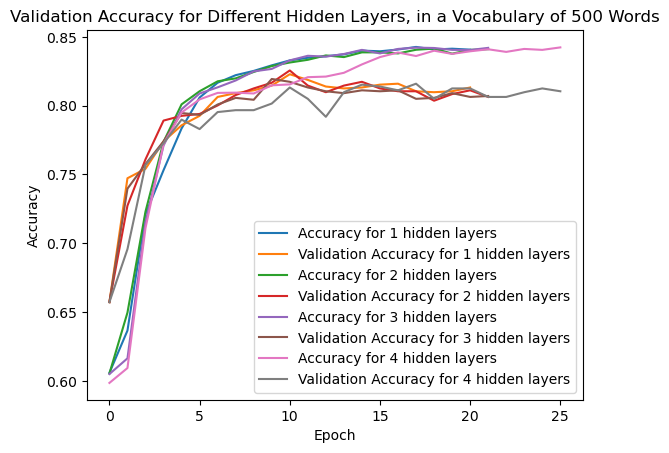

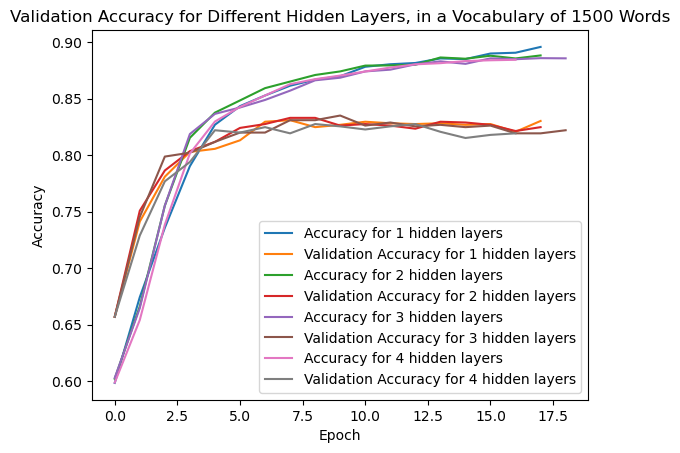

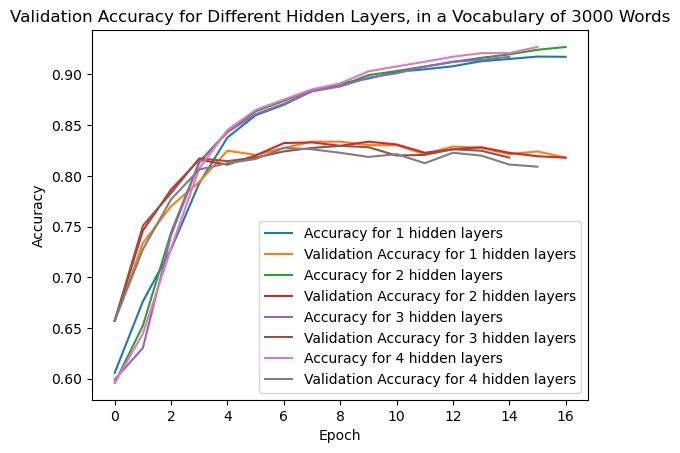

In [50]:
# Graficar los resultados para cada número de capas
plot_histories(hist_accuracy_500, hist_val_accuracy_500, 'Number of Layers', 0)
plot_histories(hist_accuracy_1500, hist_val_accuracy_1500, 'Number of Layers', 1)
plot_histories(hist_accuracy_3000, hist_val_accuracy_3000, 'Number of Layers', 2)

De las gráficas de la evolución del acierto, lo primero que vemos es que los mejores valores se obtienen para los conjuntos de 1500 i 3000 palabras. Además, tanto para uno como para el otro, observamos que para todas las versiones el acierto más elevado es parecido. Por tanto, vamos a imprimir los valores más altos, para las dos mejores versiones de todos los conjuntos, ya que no podemos escogerlo a simple vista.

---

From the graphs showing the evolution of accuracy, the first thing we notice is that the best values are obtained for the datasets of 1500 and 3000 words. Additionally, for both of these datasets, we observe that the highest accuracy values are similar across all versions. Therefore, let's print out the highest values for the two best versions of all datasets since we cannot choose them at a glance.


In [51]:
best_accuracies = {}

for i in range(1, 5):
    best_accuracies[str(500) + '_' + str(i)] = np.max(hist_accuracy_500[i])
    best_accuracies[str(1500) + '_' + str(i)] = np.max(hist_accuracy_1500[i])
    best_accuracies[str(3000) + '_' + str(i)] = np.max(hist_accuracy_3000[i])

# Obtén las dos claves con los valores más altos
best_keys = sorted(best_accuracies, key=best_accuracies.get, reverse=True)[:2]

print(best_keys, " son las dos claves con los valores más altos")
print([best_accuracies[best_keys[0]], best_accuracies[best_keys[1]]], " son las accuracies correspondientes")

['3000_4', '3000_2']  son las dos claves con los valores más altos
[0.9271109700202942, 0.9270254373550415]  son las accuracies correspondientes


Como podemos observar, los dos valores más altos son los modelos generados a partir del vocabulario de 3000 palabras. Vemos que las diferencias en el acierto máximo, obtenido por cada modelo en una epoch concreta, es mínima (menor al 0.2%). Para estudiar detenidamente como clasifica el modelo, usaremos la función classification_report.

---

As we can see, the two highest values are for the models generated from the vocabulary of 3000 words. We notice that the differences in the maximum accuracy obtained by each model at a specific epoch are minimal (less than 0.2%). To thoroughly examine how the model classifies, we will use the classification_report function.


In [52]:
# Convertir predicciones continuas a clases binarias usando un umbral
def binarize_predictions(prediction):
    threshold = 0.5  # ajusta este umbral según tu problema
    return (prediction > threshold).astype(int)

In [53]:
print("Classification Report: 3 hiden layer with 3000 words:")
print(classification_report(y_test_3000, binarize_predictions(predictions_3000[3])))
print("Classification Report: 2 hiden layer with 3000 words:")
print(classification_report(y_test_3000, binarize_predictions(predictions_3000[2])))

Classification Report: 3 hiden layer with 3000 words:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1125
           1       0.60      0.76      0.67       337

    accuracy                           0.83      1462
   macro avg       0.76      0.81      0.78      1462
weighted avg       0.85      0.83      0.84      1462

Classification Report: 2 hiden layer with 3000 words:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1125
           1       0.61      0.73      0.67       337

    accuracy                           0.83      1462
   macro avg       0.76      0.80      0.78      1462
weighted avg       0.84      0.83      0.84      1462



El modelo con 3 capas ocultas y 3000 palabras tiene una precisión global más alta (93%) en comparación con el modelo de 3 capas (92%). A pesar de esta primera métrica, todas las demás son mejos las de modelo con 2 capas. Por tanto, aunque las diferencias sean mínimas, elegiremos como mejor modelo el de 2 capas.

De todas formas, es menester darse cuenta, de que tanto un modelo como el otro, tienen una precisión muy baja de cara a la presión las muestras de la clase 1, aunque las dos tienen un buen recall respecto la misma (78% y 74%). Es posible que esto sea debido a que las muestras de esta clase representan únicamente un 23% del total. Para obtener mejores valores en cuanto a la presión sobre la clase 1.

---

The model with 3 hidden layers and 3000 words has a higher overall accuracy (93%) compared to the model with 3 layers (92%). Despite this initial metric, all other metrics are better for the model with 2 layers. Therefore, even though the differences are minimal, we will choose the model with 2 layers as the better model.

However, it is worth noting that both models have a very low precision for class 1 samples, although both have good recall for the same (78% and 74%). This may be because the samples of this class represent only 23% of the total. To obtain better values regarding the pressure on class 1, additional strategies may be necessary.